*  By: Proskurin Oleksandr
*  Email: proskurinolexandr@gmail.com
*  Reference: Advances in Financial Machine Learning, Marcos Lopez De Prado, pg 30, https://towardsdatascience.com/financial-machine-learning-part-0-bars-745897d4e4ba

In [1]:
from IPython.display import Image

# Imbalance bars generation algorithm

Let's discuss imbalance bars generation on example of volume imbalance bars. As it is desribed in Advances in Financial Machine Learning book:

First let's define what is a tick rule:

For any given $t$, where $p_t$ is the price associated with $t$ and $v_t$ is volume, the tick rule $b_t$ is defined as:

<center>$b_t = \begin{cases} b_{t-1}, & \mbox{if } \Delta p_t\mbox{=0} \\ |\Delta p_t| / \Delta p_{t}, & \mbox{if } \Delta p_t \neq\mbox{0} \end{cases}$

Tick rule is used as a proxy of trade direction, however, some data providers already provide customers with tick direction, in this case we don't need to calculate tick rule, use tick direction value instead

Cumulative volume imbalance from $1$ to $T$ is defined as:
<center>$\theta_t = \sum\limits_{t=1}^T b_t*v_t$, <center>

$T$ is the time when the bar is sampled

Next we need to define $E_0[T]$ as expected number of ticks, the book suggests to use EWMA of expected number of ticks from previously generated bars. Let's introduce the first hyperparameter for imbalance bars generation: __num_prev_bars__ which corresponds to window used for EWMA calculation.

Here we face the problem of first bar generation, because we don't know expected number of ticks with no bars generated. 
To solve this we introduce the second hyperparameter: __expected_num_ticks_init__ which corresponds to initial guess for expected number of ticks before the first imbalance bar is generated.

Bar is sampled when:
<center> $|\theta_t| >= E_0[t]*[2v^+ - E_0[v_t]$

To estimate $2v^+ - E_0[v_t]$ (expected imbalance) we simply calculate EWMA of volume imbalance from previous bars, that is why we need to store volume imbalances in _imbalance array_, the window for estimation is either __expected_num_ticks_init__ before the first bar is sampled, or expected number of ticks * __num_prev_bars__ when the first bar is generated. 

Note that when we have at least one imbalance bar generated we update $2v^+ - E_0[v_t]$ only when the next bar is sampled not on every trade observed


# Algorithm logic

Now we have understood the logic of imbalance bar generation, let's understand how the process looks in details

```python
num_prev_bars = 3
expected_num_ticks_init = 100000
expected_num_ticks = expected_num_ticks_init
cum_theta = 0
num_ticks = 0
imbalance_array = []
imbalance_bars = []
bar_length_array = []
for row in data.rows:
    #track high,low,close, volume info  
    num_ticks += 1
    tick_rule = get_tick_rule(price, prev_price)
    volume_imbalance = tick_rule * row['volume']
    imbalance_array.append(volume_imbalance)
    cum_theta += volume_imbalance
    if len(imbalance_bars) == 0:
        expected_imbalance = ewma(imbalance_array, window=expected_num_ticks_init)
       
    if abs(cum_theta) >= expected_num_ticks * abs(expected_imbalance):
        bar = form_bar(open, high, low, close, volume)
        imbalance_bars.append(bar)
        bar_length_array.append(num_ticks)
        cum_theta, num_ticks = 0, 0
        expected_num_ticks = ewma(bar_lenght_array, window=num_prev_bars)
        expected_imbalance = ewma(imbalance_array, window = num_prev_bars * expected_num_ticks)
```

Note that in algorithm pseudo-code we reset $\theta_t$ when bar is formed, in our case the formula for $\theta_t$ is:


<center>$\theta_t = \sum\limits_{t=t^*}^T b_t*v_t$, <center>
<center> $t^*$ is time when previous imbalance bar was formed<center>

Let's look at dynamics of $|\theta_t|$ and $E_0[T] * |2v^+ - E_0[v_t]|$ to understand why we decided to reset $\theta_t$ when bar is formed.
The dynamics when theta value is reset:

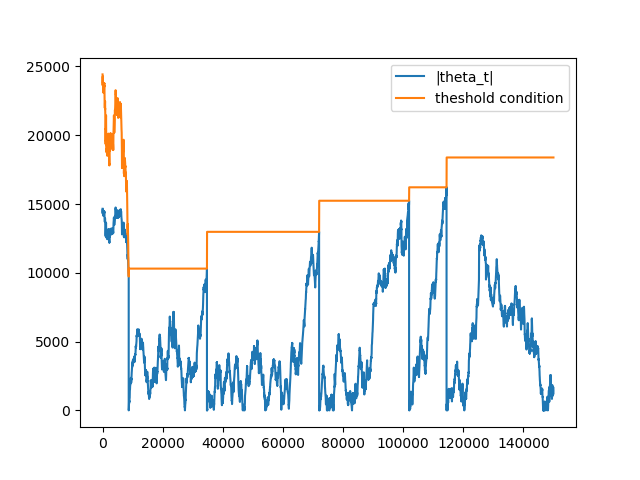

In [2]:
Image('images/mlfinlab_implementation.png')

When theta is not reset:

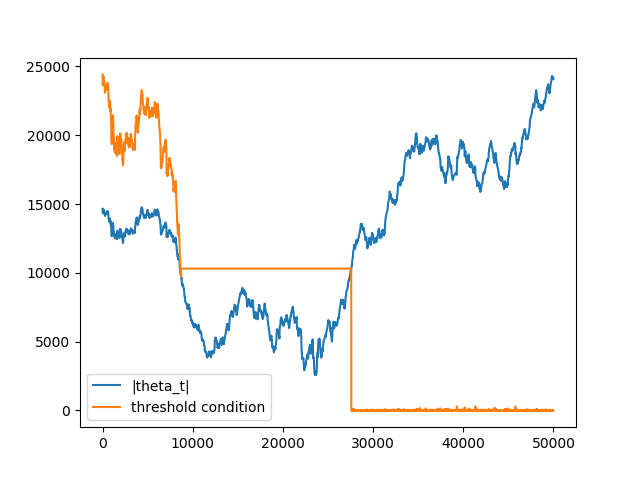

In [3]:
Image('images/book_implementation.png')

The reason for that is due to the fact that theta is accumulated, after several bars are generated and theta value is not reset $\Rightarrow$ condition is met on small number of ticks $\Rightarrow$ lenght of the next bar converges to 1 $\Rightarrow$ bar is sampled on the next consecutive tick

The logic described above is implemented in __mlfinlab__ package in _ImbalanceBars_

# Statistical properties of imbalance bars. Exercise 2.2 from the book

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import numpy as np
import pandas as pd

In [5]:
imb_bars = pd.read_csv('../Sample-Data/imbalance_bars_3_100000.csv')
dollar_bars = pd.read_csv('../Sample-Data/dollar_bars_ex_2.2.csv')

In [6]:
dollar_bars['log_ret'] = np.log(dollar_bars['close']).diff().fillna(0) # get log returns
imb_bars['log_ret'] = np.log(imb_bars['close']).diff().fillna(0)

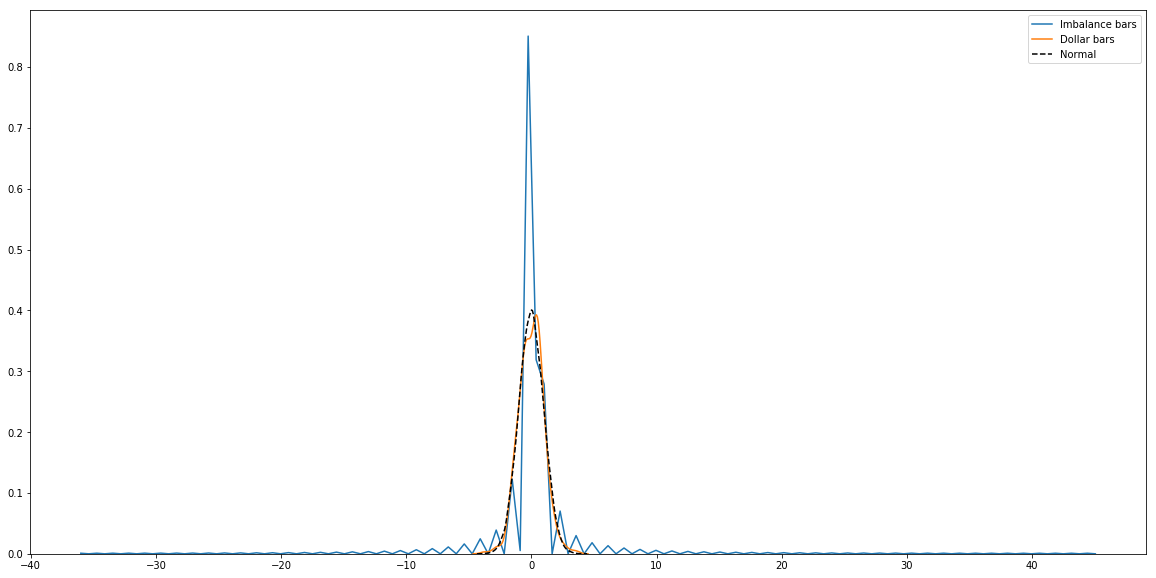

In [7]:
plt.figure(figsize=(20,10))
sns.kdeplot((imb_bars.log_ret - imb_bars.log_ret.mean()) / imb_bars.log_ret.std(), label="Imbalance bars")
sns.kdeplot((dollar_bars.log_ret - dollar_bars.log_ret.mean()) / dollar_bars.log_ret.std(), label="Dollar bars")
sns.kdeplot(np.random.normal(size=len(imb_bars)), label="Normal", color='black', linestyle="--")

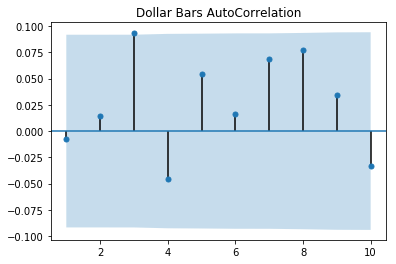

In [8]:
plot_acf(dollar_bars.log_ret, lags=10, zero=False)
plt.title('Dollar Bars AutoCorrelation')
plt.show()

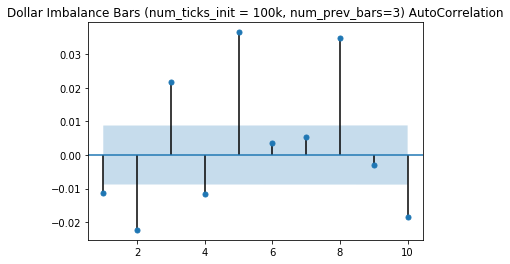

In [9]:
plot_acf(imb_bars.log_ret, lags=10, zero=False)
plt.title('Dollar Imbalance Bars (num_ticks_init = 100k, num_prev_bars=3) AutoCorrelation')
plt.show()